In many domains it is common to plot scalar values as a function of time (or other single dimensions).  As long as the total number of datapoints is relatively low (in the tens of thousands, perhaps) and there are only a few separate curves involved, most plotting packages will do well.  However, for longer or more frequent sampling, you'll be required to subsample your data before plotting, potentially missing important peaks or troughs in the data.  And even just a few timeseries visualized together quickly run into highly misleading [overplotting](https://anaconda.org/jbednar/plotting_problems/notebook) issues, making the most recently plotted curves unduly prominent.

For applications with many datapoints or when visualizing multiple curves, datashader provides a principled way to view *all* of your data.  In this example, we will synthesize several time-series curves so that we know their properties, and then show how datashader can reveal them.

In [1]:
import datetime
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf
from collections import OrderedDict

### Create some fake timeseries data

Here we create a fake time series signal, then generate many noisy versions of it.  We will also add a couple of "rogue" lines, with different statistical properties, and see how well those stand out from the rest.

In [2]:
# Constants
np.random.seed(2)
n = 100000                               # Number of points
cols = list('abcdefg')                   # Column names of samples
start = datetime.datetime(2010, 10, 1, 0)   # Start time

# Generate a fake signal
signal = np.random.normal(0, 0.3, size=n).cumsum() + 50

# Generate many noisy samples from the signal
noise = lambda var, bias, n: np.random.normal(bias, var, n)
data = {c: signal + noise(1, 10*(np.random.random() - 0.5), n) for c in cols}

# Add some "rogue lines" that differ from the rest 
cols += ['x'] ; data['x'] = signal + np.random.normal(0, 0.02, size=n).cumsum() # Gradually diverges
cols += ['y'] ; data['y'] = signal + noise(1, 20*(np.random.random() - 0.5), n) # Much noisier
cols += ['z'] ; data['z'] = signal # No noise at all

# Pick a few samples from the first line and really blow them out
locs = np.random.choice(n, 10)
data['a'][locs] *= 2

# Create a dataframe
data['Time'] = [start + datetime.timedelta(minutes=1)*i for i in range(n)]

df = pd.DataFrame(data)
df.tail()

Time          a          b          c          d  \
99995 2010-12-09 10:35:00 -43.266888 -51.619471 -42.867714 -45.723507   
99996 2010-12-09 10:36:00 -42.733578 -51.773237 -42.984615 -45.269990   
99997 2010-12-09 10:37:00 -42.614768 -51.268256 -42.201864 -45.497689   
99998 2010-12-09 10:38:00 -44.684017 -50.131985 -42.204521 -45.856321   
99999 2010-12-09 10:39:00 -46.027779 -50.496361 -42.615223 -45.025591   

               e          f          g          x          y          z  
99995 -47.229012 -44.246641 -46.509765 -54.598808 -44.922483 -48.523868  
99996 -45.537120 -45.258385 -44.763207 -54.623914 -45.116631 -48.523325  
99997 -46.426903 -45.170198 -45.393405 -53.837847 -44.981804 -47.741589  
99998 -48.606589 -45.880804 -46.653791 -53.910759 -43.639239 -47.806325  
99999 -46.462669 -43.848973 -47.319626 -54.216269 -45.546920 -48.076312

The native datashader API illustrated here does not support datetimes directly so we create a new column casting the datetimes to integer:

In [17]:
df['Time'] = pd.to_datetime(df['Time'])
df['ITime'] = pd.to_numeric(df['Time'])

Now we can compute the x- and y-ranges:

In [19]:
# Default plot ranges:
x_range = (df.iloc[0].ITime, df.iloc[-1].ITime)
y_range = (1.2*signal.min(), 1.2*signal.max())

print("x_range: {0} y_range: {0}".format(x_range,y_range))

x_range: (1285891200000000000, 1291891140000000000) y_range: (1285891200000000000, 1291891140000000000)


In [20]:
x_range


(1285891200000000000, 1291891140000000000)

### Plotting *all* the datapoints

With datashader, we can plot *all* the datapoints for a given timeseries.  Let's select the first curve 'a' and draw it into an aggregate grid, connecting each datapoint in the series:

In [21]:
y_range 

(-104.8094774985483, 100.09816883332905)

In [22]:
%%time
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
aggs= OrderedDict((c, cvs.line(df, 'ITime', c)) for c in cols)
img = tf.shade(aggs['a'])

Wall time: 6.49 s


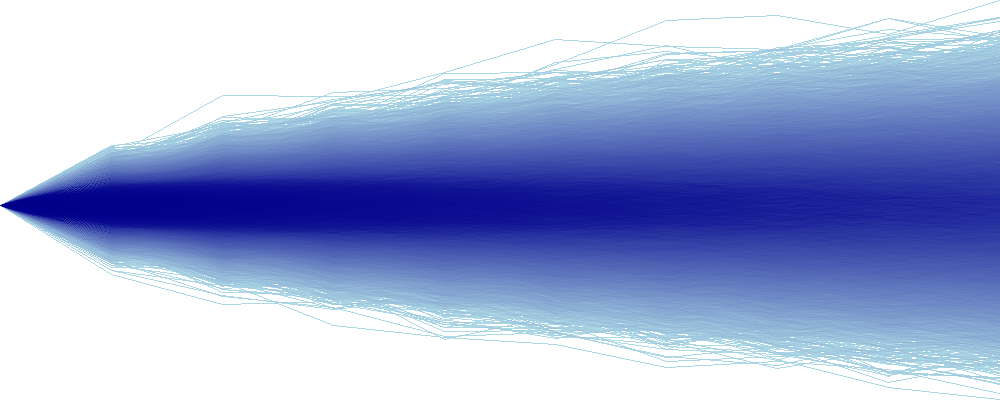

In [48]:
img


The result looks similar to what you might find in any plotting program, but it uses all 100,000 datapoints, and would work similarly for 1, 10, or 100 million points (determined by the `n` attribute above).  

Why is using all the datapoints important? To see, let's downsample the data by a factor of 10, plotting 10,000 datapoints for the same curve:

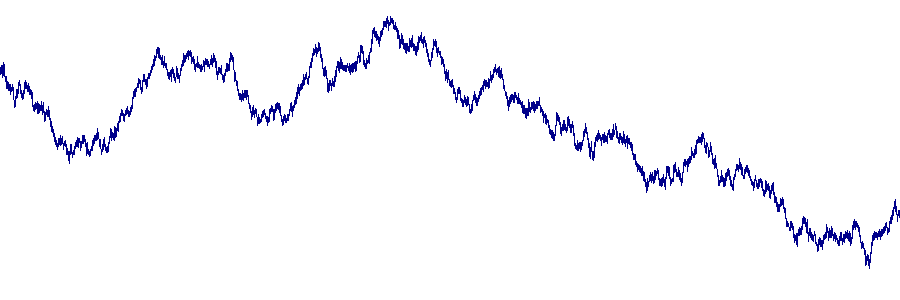

In [24]:
mask = (df.index % 10) == 0
tf.shade(cvs.line(df[mask][['a','ITime']], 'ITime', 'a'))

The resulting plot is similar, but now none of the "blown up" datapoints (sharp spikes) that were clearly visible in the first version are visible at all!  They didn't happen to be amongst the sampled points, and thus do not show up in this plot, which should never be a problem using datashader with all the points.


### Overplotting problems

What happens if we then overlay multiple such curves?  In a traditional plotting program, there would be serious issues with overplotting, because these curves are highly overlapping.  To show what would typically happen, let's merge the images corresponding to each of the curves:

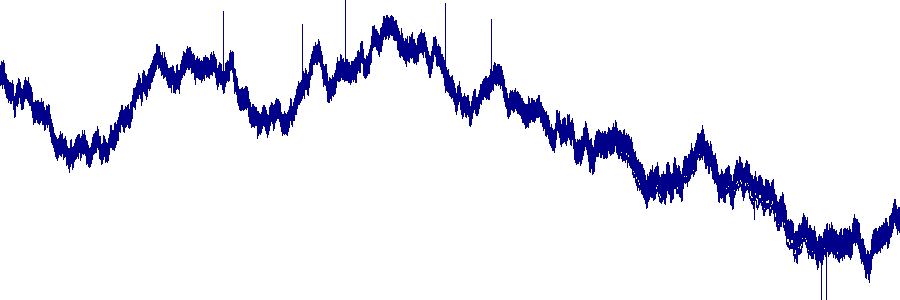

In [25]:
renamed = [aggs[key].rename({key: 'value'}) for key in aggs]
merged = xr.concat(renamed, 'cols')
tf.shade(merged.any(dim='cols'))

The `any` operator merges all the data such that any pixel that is lit up for any curve is lit up in the final result.  Clearly, it is difficult to see any structure in this fully overplotted data; all we can see is the envelope of these curves, i.e. the minimum and maximum value of any curve for any given time point. It remains completely unclear how the various curves in the set relate to each other.  Here we know that we put in one particularly noisy curve, which presumably determines the envelope, but there's no way to tell that from the plot.

We can of course try giving each curve a different color:

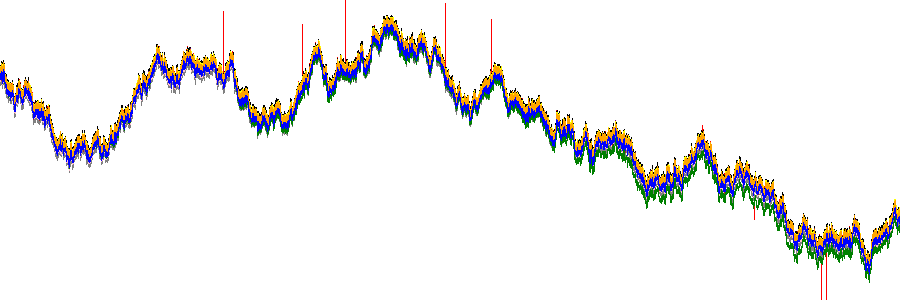

In [26]:
colors = ["red", "grey", "black", "purple", "pink",
          "yellow", "brown", "green", "orange", "blue"]
imgs = [tf.shade(aggs[i], cmap=[c]) for i, c in zip(cols, colors)]
tf.stack(*imgs)

But that doesn't help much; there are 10 curves, but only three or four colors are visible, due to overplotting.  Problems like that will just get much worse if there are 100, 1000, or 1 million curves.  Moreover, the results will look entirely different if we plot them in the opposite order:

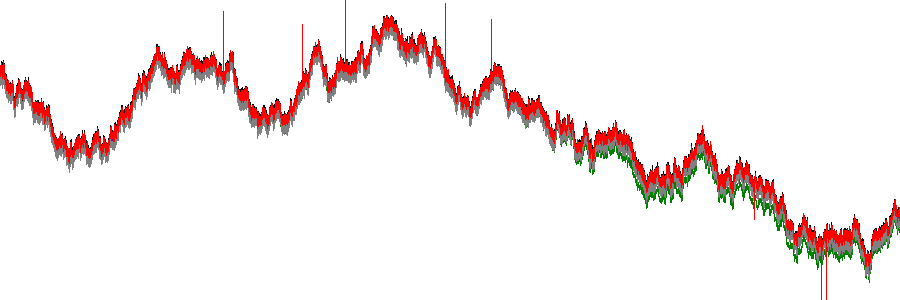

In [27]:
tf.stack(*reversed(imgs))

Having the visualization look completely different for an arbitrary choice like the plotting order is a serious problem if we want to understand the properties of this data, from the data itself.

### Trends and outliers

So, what might we be interested in understanding when plotting many curves?  One possibility is the combination of (a) the overall trends, and (b) any curves (and individual datapoints) that differ from those trends.  

To look at the trends, we should combine the plots not by overplotting as in each of the above examples, but using operators that accurately reveal overlap between the curves.  When doing so, we won't try to discern individual curves directly by assigning them unique colors, but instead try to show areas of the curves that establish the trends and differ from them.  (Assigning colors per curve could be done as for the racial categories in census.ipynb, but that won't be further investigated here.)

Instead of the `.any()` operator above that resulted in complete overplotting, or the `tf.stack` operator that depended strongly on the plotting order, let's use the `.sum()` operator to reveal the full patterns of overlap arithmetically:

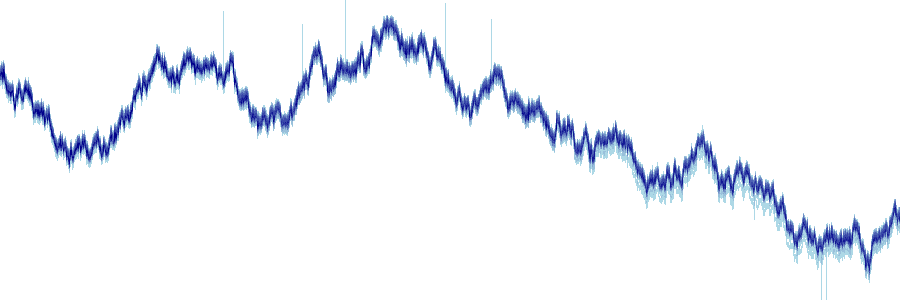

In [28]:
total = tf.shade(merged.sum(dim='cols'), how='linear')
total

With study, the overall structure of this dataset should be clear, according to what we know we put in when we created them:

1. Individual rogue datapoints from curve 'a' are clearly visible (the seven sharp spikes)
2. The trend is clearly visible (for the viridis colormap, the darkest greens show the areas of highest overlap)
3. Line 'x' that gradually diverges from the trend is clearly visible (as the light blue (low-count) areas that increase below the right half of the plot).

(Note that if you change the random seed or the number of datapoints, the specific values and locations will differ from those mentioned in the text.)

None of these observations would have been possible with downsampled, overplotted curves as would be typical of other plotting approaches.


### Highlighting specific curves

The data set also includes a couple of traces that are difficult to detect in the `.sum()` plot above, one with no noise and one with much higher noise.  One way to detect such issues is to highlight each of the curves in turn, and display it in relation to the datashaded average values.  For instance, those two curves (each highlighted in red below) stand out against the pack as having less or more noise than is typical:

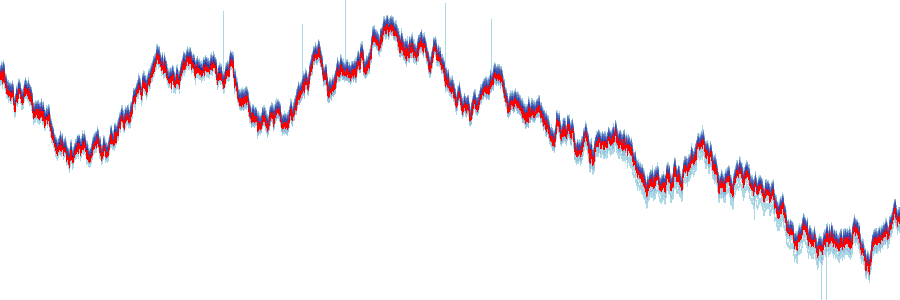

In [29]:
tf.stack(total, tf.shade(aggs['z'], cmap=["lightblue", "red"]))

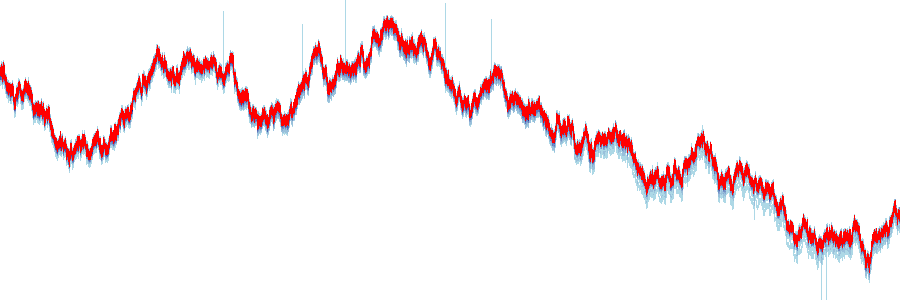

In [30]:
tf.stack(total, tf.shade(aggs['y'], cmap=["lightblue", "red"]))

### Area plots
As an alternative to plotting time-series data as a line, the same data can be plotted as a filled area plot.  This approach serves to emphasise whether the time series has a positive or negative sign.  Here is an example of a filled area plot for the 'a' curve.

In [32]:
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
agg = cvs.Area(df, x='ITime', y='a')
img = tf.shade(agg)
img

AttributeError: 'Canvas' object has no attribute 'Area'

By specifying the y_stack argument, an area plot can also be used to display the difference between two curves.  Here is an example of an area plot of the difference between the 'a' and 'b' curves

In [ ]:
cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=300, plot_width=900)
agg = cvs.area(df, x='ITime', y='a', y_stack='b')
img = tf.shade(agg)
img

### Dynamic Plots

In practice, it might be difficult to cycle through each of the curves to find one that's different, as done above.  Perhaps a criterion based on similarity could be devised, choosing the curve most dissimilar from the rest to plot in this way, which would be an interesting topic for future research.  In any case, one thing that can be achieved with [HoloViews](http://holoviews.org/) is to make the plot fully interactive, with direct support for datetimes so that the viewer can zoom in and discover such patterns dynamically with correctly formatted axes.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
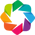

In [35]:
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

If you are looking at a live, running version of this notebook, just enable the wheel zoom or box zoom tools, and then zoom and pan as you wish:

In [36]:
opts = hv.opts.RGB(width=600, height=300)
ndoverlay = hv.NdOverlay({c:hv.Curve((df['Time'], df[c]), kdims=['Time'], vdims=['Value']) for c in cols})
datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts)

:DynamicMap   []
   :RGB   [Time,Value]   (R,G,B,A)

Here the diverging "rogue line" is immediately apparent, and if you zoom in towards the right you can see precisely how it differs from the rest.  The low-noise "rogue line" is much harder to see, but if you zoom in enough (particularly if you stretch out the x axis by zooming on the axis itself), you can see that one line goes through the middle of the pack, with different properties from the rest.  The datashader team is working on support for hover-tool information to reveal what line that was, and in general on better support for exploring large timeseries (and other curve) data.

### Multiple trends

The above curves were very highly overlapping to illustrate a worst-case scenario, but now let's look at a case with curves that diverge more strongly from each other.   For instance, imagine that we have a simulation where one of three qualitatively different decisions are made at the starting time (perhaps three different parameter settings), along with noisy samples from each group, and we want to see what effect that has on the overall expected state into the future.  

Now, let's create time series in three different groups, each of which are similar to each other, but each group differing from each other as they diverge from a common starting point.  For instance, in a simulation run, each group could be from setting a different parameter, while each noisy version could be different runs with a different seed.

In [37]:
signals = [np.random.normal(0, 0.3, size=n).cumsum() + 50,
           np.random.normal(0, 0.3, size=n).cumsum() + 50,
           np.random.normal(0, 0.3, size=n).cumsum() + 50]
data = {c: signals[i%3] + noise(1+i, 5*(np.random.random() - 0.5), n)  for (i,c) in enumerate(cols)}
y_range = (1.2*min([s.min() for s in signals]), 1.2*max([s.max() for s in signals]))    

data['Time'] = df['Time']
df = pd.DataFrame(data)

And let's examine the result interactively:

In [38]:
opts = hv.opts.RGB(width=600, height=300)
ndoverlay = hv.NdOverlay({c:hv.Curve((df['Time'], df[c]), vdims=['Time']) for c in cols})
datashade(ndoverlay, normalization='linear', aggregator=ds.count()).opts(opts) # BoxZoomTool(match_aspect=True)

:DynamicMap   []
   :RGB   [x,Time]   (R,G,B,A)

Here the three groups can clearly be seen, at least once they diverge sufficiently, as well as the areas of high overlap (high probability of being in that state at that time). Additional patterns are visible when zooming in, all the way down to the individual datapoints, and again it may be useful to zoom first on the x axis (to make enough room on your screen to distinguish the datapoints, since there are 100,000 of them and only a few thousand pixels at most on your screen!). And note again that the interactive plots require a running server if you want to see more datapoints as you zoom in; static exports of this notebook won't support full zooming.

# Plotting large numbers of time series together

The examples above all used a small number of very long time series, which is one important use case for Datashader.  Another important use case is visualizing very large numbers of time series, even if each individual curve is relatively short. If you have hundreds of thousands of timeseries, putting each one into a Pandas dataframe column and aggregating it individually will not be very efficient. 

Luckily, Datashader can render arbitrarily many separate curves, limited only by what you can fit into a Dask dataframe (which in turn is limited only by your system's total disk storage). Instead of having a dataframe where each pair of columns (one for `x` one for `y`) represents a curve, you can have a dataframe where each row represents a fixed-length curve.  In this case, the `x` and `y` arguments should be set to lists of the labels of the columns that represent the curve coordinates and the `axis` argument should be set to 1.  If all of the lines share the same coordinates for one of the dimensions, then the corresponding argument (either `x` or `y`) can be replaced with a 1-dimensional NumPy array containing these coordinates.

In this way you can plot millions or billions of fixed-length curves efficiently.

As an example, let's generate a NumPy array containing 100,000 sequences with 10 points each, where each sequence represents a 1-dimensional random walk with step size drawn from the standard normal distribution:

In [39]:
n = 100000
points = 10
time = np.linspace(0, 1, points)
data = np.cumsum(np.c_[np.zeros((n,1)), np.random.randn(n, points)] , axis=1)
data.shape

(100000, 11)

We can create a Pandas dataframe from this NumPy array directly, where each row in the resulting dataframe represents an independent trial of the random walk:

In [40]:
df = pd.DataFrame(data)
df.head(15)

0         1         2         3         4         5         6         7   \
0   0.0  0.377222 -0.249735 -1.194367 -1.380634 -0.671281  0.040787 -0.156663   
1   0.0 -1.403119 -2.378427 -4.830572 -4.935300 -4.924859 -2.114318 -1.906418   
2   0.0 -1.352935 -0.608178 -0.667442 -0.502931 -1.786608 -2.136291 -4.458136   
3   0.0 -0.716378 -0.244081 -0.951915 -2.497982 -2.557246 -3.183032 -3.065062   
4   0.0  0.762461 -0.156942 -1.275631 -0.866515 -0.972335 -1.165401 -0.391618   
5   0.0 -0.070304 -1.927411 -4.105959 -4.774451 -4.660079 -4.846771 -3.551492   
6   0.0  0.860222 -0.533911 -0.910240 -0.202988  0.236928 -1.937484 -4.459690   
7   0.0 -0.496851  1.005509  1.465258  0.580072 -0.483865 -0.071584 -1.954305   
8   0.0  2.195455  1.946487  0.243154  2.269577  3.185899  4.204509  2.511518   
9   0.0  0.073215 -0.361441 -0.074260 -0.055021  0.451899 -0.522455 -1.334748   
10  0.0  0.329212  0.594557 -0.532055  0.378673  0.745532  1.055768  1.243595   
11  0.0 -0.815413 -2.223627 -0.809400 -2.561691 -3.117988 -4.467533 -7.045296   
12  0.0  0.358719  1.029473  0.944431 -0.047894 -1.121161 -0.529860 -1.632196   
13  0.0  0.584170  1.392100  1.240867  2.669086  2.555953  2.512450  4.762607   
14  0.0  0.252747  1.392970  0.957619  0.077459  0.189394 -1.974626 -1.744716   

          8         9         10  
0  -0.759360 -1.081526  1.554707  
1  -1.540874 -0.510023  2.564636  
2  -4.872798 -3.712484 -4.120521  
3  -4.547952 -5.034308 -7.086219  
4  -0.070743 -0.955226 -0.381761  
5  -3.181119 -2.579117 -2.828520  
6  -5.201604 -5.191556 -5.331570  
7  -2.183242 -0.257736 -0.202729  
8   1.103528  2.888355  3.317844  
9  -1.011224 -2.124819 -2.311535  
10  2.097591  3.091042  3.351349  
11 -6.748950 -6.662267 -6.865935  
12 -1.512300 -1.607074 -1.750311  
13  2.489497  1.581741  0.497938  
14 -1.760675 -1.828831 -0.953880

To render these lines we set the `x` argument to `time` (the 1-dimensional NumPy array containing the shared x coordinates) the `y` argument to `list(range(points))` (a list of the column labels of `df` the contain the y coordinates of each line), and the `axis` argument to `1` (indicating that each row of the dataframe represents a line rather than each pair of columns).

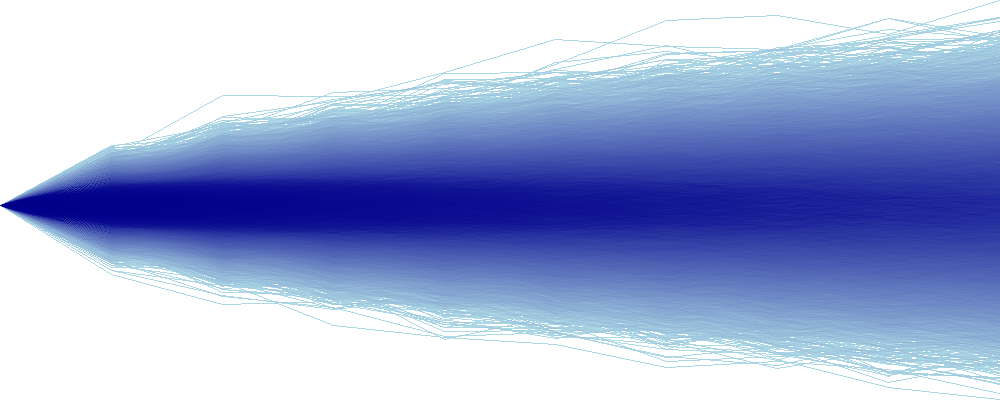

In [41]:
cvs = ds.Canvas(plot_height=400, plot_width=1000)
agg = cvs.line(df, x=time, y=list(range(points)), agg=ds.count(), axis=1)
img = tf.shade(agg, how='eq_hist')
img

Here, each line represents an independent trial of this random walk process.  All lines start from the same point at time 0 (all the way to the left). At each subsquent time step, each line moves upward or downward from its prior position by a distance drawn from a normal distribution.  Thanks to the nonlinear `eq-hist` colorization, you can see the dispersion in the density of the overall distribution as time advances, at the same time as you can see the individual outliers at the extremes of the distribution.  You'll see a similar plot for 1,000,000 or 10,000,000 curves, and much more interesting plots if you have real data to show!